Observe the influence of the beta coefficient for the regularization DKL

In [116]:
import pandas as pd
import torch
import numpy as np
import random

from vibtcr.dataset import TCRDataset
from vibtcr.mvib.mvib import MVIB
from vibtcr.mvib.mvib_trainer import TrainerMVIB

from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [117]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
import pandas as pd
import torch

metrics = [
    'auROC',
    'Accuracy',
    'Recall',
    'Precision',
    'F1 score',
    'auPRC'
]

def pr_auc(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return pr_auc

def get_scores(y_true, y_prob, y_pred):
    """
    Compute a df with all classification metrics and respective scores.
    """
    
    scores = [
        roc_auc_score(y_true, y_prob),
        accuracy_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        pr_auc(y_true, y_prob)
    ]
    
    df = pd.DataFrame(data={'score': scores, 'metrics': metrics})
    return df

In [118]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

In [119]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"

In [120]:
device = torch.device('cuda:4')

batch_size = 4096
epochs = 500
lr = 1e-3

z_dim = 150
early_stopper_patience = 50
monitor = 'auROC'
lr_scheduler_param = 10
joint_posterior = "aoe"

In [ ]:
df1 = pd.read_csv(DATA_BASE + 'alpha-beta-splits/beta.csv')
df2 = pd.read_csv(DATA_BASE + 'alpha-beta-splits/alpha-beta.csv')
df = pd.concat([df1, df2]).reset_index()

df_results_list = []

for beta in [0, 1e-8, 1e-6, 1e-4, 1e-2, 1]:
    for i in range(5):  # 5 independent train/test splits
        set_random_seed(i)

        df_train, df_test = train_test_split(df.copy(), test_size=0.2, random_state=i)
        scaler = TCRDataset(df_train.copy(), torch.device("cpu"), cdr3b_col='tcrb', cdr3a_col=None).scaler

        ds_test = TCRDataset(df_test, torch.device("cpu"), cdr3b_col='tcrb', cdr3a_col=None, scaler=scaler)

        df_train, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train.sign, random_state=i)

        # train loader with balanced sampling
        ds_train = TCRDataset(df_train, device, cdr3b_col='tcrb', cdr3a_col=None, scaler=scaler)
        class_count = np.array([df_train[df_train.sign == 0].shape[0], df_train[df_train.sign == 1].shape[0]])
        weight = 1. / class_count
        samples_weight = torch.tensor([weight[s] for s in df_train.sign])
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
        train_loader = torch.utils.data.DataLoader(
            ds_train,
            batch_size=batch_size,
            sampler=sampler
        )

        # val loader with balanced sampling
        ds_val = TCRDataset(df_val, device, cdr3b_col='tcrb', cdr3a_col=None, scaler=scaler)
        class_count = np.array([df_val[df_val.sign == 0].shape[0], df_val[df_val.sign == 1].shape[0]])
        weight = 1. / class_count
        samples_weight = torch.tensor([weight[s] for s in df_val.sign])
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
        val_loader = torch.utils.data.DataLoader(
            ds_val,
            batch_size=batch_size,
            sampler=sampler
        )

        model = MVIB(z_dim=z_dim, device=device, joint_posterior=joint_posterior).to(device)

        trainer = TrainerMVIB(
            model,
            epochs=epochs,
            lr=lr,
            beta=beta,
            checkpoint_dir=".",
            mode="bimodal",
            lr_scheduler_param=lr_scheduler_param
        )
        checkpoint = trainer.train(train_loader, val_loader, early_stopper_patience, monitor)    

        # test
        model = MVIB.from_checkpoint(checkpoint, torch.device("cpu"))
        pred = model.classify(pep=ds_test.pep, cdr3b=ds_test.cdr3b, cdr3a=None)
        pred = pred.detach().numpy()
        df_results = get_scores(df_test.sign.tolist(), pred.squeeze().tolist(), pred.squeeze().round().tolist())
        df_results['beta'] = beta
        df_results_list.append(df_results)


[VAL] Best epoch 222 | Score -0.816008 | DKL-prior 0.000000 | BCE 0.768609 | auROC 0.8160:  54%|█████▍    | 271/500 [21:26<18:07,  4.75s/it]
[VAL] Best epoch 387 | Score -0.812416 | DKL-prior 0.000000 | BCE 0.917613 | auROC 0.8124:  87%|████████▋ | 436/500 [34:12<05:01,  4.71s/it]
[VAL] Best epoch 50 | Score -0.790671 | DKL-prior 0.000000 | BCE 0.576704 | auROC 0.7907:  10%|█         | 52/500 [04:03<34:30,  4.62s/it]

In [128]:
df = pd.concat(df_results_list).reset_index(drop=True)

df = df.rename(columns={'score': 'Score', 'beta': 'β', 'metrics': 'Metric'})

rename_metrics = {
    'auROC': 'AUROC',
    'auPRC': 'AUPR',
    'F1 score': 'F1',
    'Accuracy': 'Accuracy',
    'Recall': 'Recall',
    'Precision': 'Precision'
}

In [129]:
beta_labels = [0, 1e-8, 1e-6, 1e-4, 1e-2, 1]
beta_labels_str = ['0', '1e-8', '1e-6', '1e-4', '1e-2', '1']
beta_ticks = [0, 1, 2, 3, 4, 5]
l2t = {
    k: v for k, v in zip(beta_labels, beta_ticks)
}
t2l = {
    k: v for k, v in zip(beta_ticks, beta_labels)
}
df['Metric'] = df['Metric'].apply(lambda x: rename_metrics[x])
df = df[df['β'].isin(beta_labels)]
df['β'] = df['β'].apply(lambda x: l2t[x])

Text(0.5, 1.0, 'Effect of β | Human TCR set')

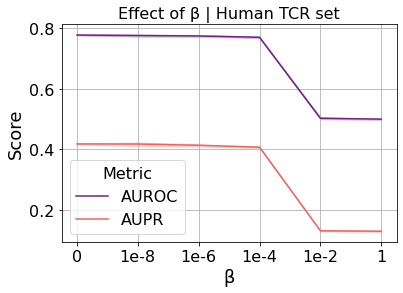

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


sns.set_palette("magma",2)
df = df[df['Metric'].isin(['AUROC', 'AUPR'])]
ax = sns.lineplot(data=df, x="β", y="Score", hue="Metric", )
ax.set_xticks(beta_ticks)
ax.set_xticklabels(beta_labels_str)
ax.grid(axis='y')
ax.grid(axis='x')
ax.set_title('Effect of β | Human TCR set')

In [ ]:
plt.savefig(FIGURES_BASE + "beta-influence.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_BASE + "beta-influence.png", format='png', dpi=300, bbox_inches='tight')

In [127]:
df

,Score,Metric,β
0,0.775348,AUROC,0
5,0.415855,AUPR,0
6,0.776495,AUROC,0
11,0.418079,AUPR,0
12,0.781580,AUROC,0
17,0.418035,AUPR,0
18,0.775013,AUROC,0
23,0.414710,AUPR,0
24,0.778356,AUROC,0
29,0.420391,AUPR,0
